In [ ]:
!nvidia-smi

Thu May 12 07:14:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import modules

In [ ]:
import torch

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100
from torch.cuda import is_available
from torchvision import transforms
from datetime import datetime

%matplotlib inline

In [ ]:
device='cuda' if is_available() else 'cpu'
device

'cuda'

# Download dataset and calculate means and stds

In [ ]:
all_data=CIFAR100(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to .
Mean: 0.50707513 0.48654887 0.44091785
Std: 0.20079845 0.19834627 0.20219834


# Implement CustomSubset

To use different augmentations to train subset and validation subset.

In [ ]:
class CustomSubset(Dataset):
    def __init__(self,Subset,transform=None):
        super(CustomSubset,self).__init__()
        self.Subset=Subset
        self.indices=Subset.indices
        self.transform=transform

    def __len__(self):
        return len(self.Subset)

    def __getitem__(self,idx):
        img,label=self.Subset[idx]
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [ ]:
transform={
    'train':transforms.Compose([
                                transforms.RandomCrop((32, 32), padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ]),
    'test':transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize([meanR,meanG,meanB],[stdR,stdG,stdB])
            ])
}

train_ratio=0.8
train_data_len=int(len(all_data)*0.8)
valid_data_len=len(all_data)-train_data_len

train_data,valid_data=random_split(all_data,[train_data_len,valid_data_len])

all_data.transform=None
train_data=CustomSubset(train_data,transform['train'])
valid_data=CustomSubset(valid_data,transform['test'])
test_data=CIFAR100(root='.',train=False,transform=transform['test'],download=True)

Files already downloaded and verified


# Define blocks

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.residual_function = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                               nn.BatchNorm2d(out_channels),
                                               nn.ReLU(inplace=True),
                                               nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
                                               nn.BatchNorm2d(out_channels * BasicBlock.expansion))
        
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(out_channels * BasicBlock.expansion))
            
    def forward(self, x):
        return F.relu(self.residual_function(x) + self.shortcut(x), inplace=True)


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        self.residual_function = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                                               nn.BatchNorm2d(out_channels),
                                               nn.ReLU(inplace=True),
                                               nn,Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
                                               nn.BatchNorm2d(out_channels),
                                               nn.ReLU(inplace=True),
                                               nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
                                               nn.BatchNorm2d(out_channels * BottleNeck.expansion))
    
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(out_channels * BasicBlock.expansion))
            
    def forward(self, x):
        return F.relu(self.residual_function(x) + self.shortcut(x), inplace=True)

# Define ResNet18

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True))
        
        self.conv2_x = nn.Sequential(BasicBlock(64, 64, stride=1),
                                     BasicBlock(64, 64, stride=1))
        
        self.conv3_x = nn.Sequential(BasicBlock(64, 128, stride=2),
                                     BasicBlock(128, 128, stride=2))
        
        self.conv4_x = nn.Sequential(BasicBlock(128, 256, stride=2),
                                     BasicBlock(256, 256, stride=2))
        
        self.conv5_x = nn.Sequential(BasicBlock(256, 512, stride=2),
                                     BasicBlock(512, 512, stride=2))
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

# Prepare training step

In [ ]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
model = ResNet18(num_classes=100)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)

model = model.to(device)
criterion = criterion.to(device)

# Train and validation

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10, print_every=1, early_stop=None, model_path='resnet18.pth'):
    train_logs = {'Loss':[], 'Accuracy':[]}
    valid_logs = {'Loss':[], 'Accuracy':[]}
    try:
        patience = 0
        best_acc = -np.inf
        start_time = datetime.now()
        for epoch in range(num_epochs):
            train_loss = 0
            valid_loss = 0
            train_acc = 0
            valid_acc = 0
            # training step
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                data, target = data.to(device), target.to(device)
                pred = model(data)
                loss = criterion(pred,target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                train_acc += torch.sum(pred.argmax(1) == target).item()
            train_loss /= len(train_data)
            train_acc /= len(train_data)
            train_logs['Loss'].append(train_loss)
            train_logs['Accuracy'].append(train_acc)
            if (epoch + 1) % print_every == 0:
                print('Training   Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch, train_loss, train_acc * 100, datetime.now() - start_time))
            # validation step
            with torch.no_grad():
                model.eval()
                for data, target in valid_loader:
                    data, target = data.to(device), target.to(device)
                    pred = model(data)
                    loss = criterion(pred,target)
                    valid_loss += loss.item() * data.size(0)
                    valid_acc += torch.sum(pred.argmax(1) == target).item()
                valid_loss /= len(valid_data)
                valid_acc /= len(valid_data)
                valid_logs['Loss'].append(valid_loss)
                valid_logs['Accuracy'].append(valid_acc)
                if (epoch+1) % print_every == 0:
                    print('Validation Epoch {} - Loss : {:.8f} Accuracy : {:.4f}% Time elapsed: {}'.format(epoch, valid_loss, valid_acc * 100, datetime.now() - start_time))
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    torch.save(model.state_dict(), model_path)
                    if early_stop is not None:
                        patience = 0
                elif early_stop is not None:
                    patience += 1
                    if patience >= early_stop:
                        print('Training finished by early stopping')
                        return train_logs, valid_logs
        return train_logs, valid_logs
    except KeyboardInterrupt:
        return train_logs, valid_logs

In [ ]:
train_logs, valid_logs = train(model=model,
                               criterion=criterion,
                               optimizer=optimizer,
                               train_loader=train_loader,
                               valid_loader=valid_loader,
                               num_epochs=50,
                               print_every=1,
                               early_stop=None,
                               model_path='resnet18.pth')

Training   Epoch 0 - Loss : 4.28088884 Accuracy : 4.2850% Time elapsed: 0:00:42.646297
Validation Epoch 0 - Loss : 4.12651142 Accuracy : 5.3000% Time elapsed: 0:00:46.204924
Training   Epoch 1 - Loss : 3.97672052 Accuracy : 7.2050% Time elapsed: 0:01:28.578175
Validation Epoch 1 - Loss : 4.02149058 Accuracy : 6.5700% Time elapsed: 0:01:31.998426
Training   Epoch 2 - Loss : 3.87543466 Accuracy : 8.9500% Time elapsed: 0:02:14.882827
Validation Epoch 2 - Loss : 4.03295276 Accuracy : 8.0600% Time elapsed: 0:02:18.293936
Training   Epoch 3 - Loss : 3.79123206 Accuracy : 10.2575% Time elapsed: 0:03:00.799620
Validation Epoch 3 - Loss : 3.79705979 Accuracy : 9.7100% Time elapsed: 0:03:04.234345
Training   Epoch 4 - Loss : 3.71553122 Accuracy : 11.7250% Time elapsed: 0:03:46.616628
Validation Epoch 4 - Loss : 3.65600023 Accuracy : 11.9900% Time elapsed: 0:03:50.272421
Training   Epoch 5 - Loss : 3.65350983 Accuracy : 12.7175% Time elapsed: 0:04:32.398860
Validation Epoch 5 - Loss : 3.57516919 

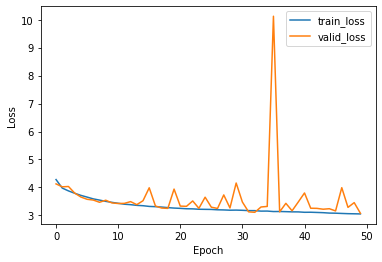

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot([i for i in range(len(train_logs['Loss']))], train_logs['Loss'], label='train_loss')
plt.plot([i for i in range(len(valid_logs['Loss']))], valid_logs['Loss'], label='valid_loss')
plt.legend()
plt.show()

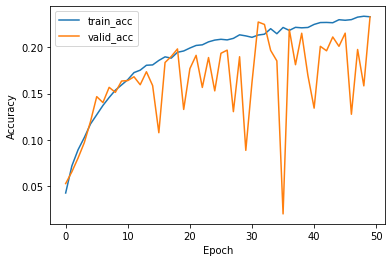

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot([i for i in range(len(train_logs['Accuracy']))], train_logs['Accuracy'], label='train_acc')
plt.plot([i for i in range(len(valid_logs['Accuracy']))], valid_logs['Accuracy'], label='valid_acc')
plt.legend()
plt.show()

# Test

In [ ]:
model.load_state_dict(torch.load('resnet18.pth'))
model = model.to(device)

In [ ]:
def test(model,criterion,test_loader):
    test_loss = 0
    test_acc = 0
    result_table = pd.DataFrame(columns=['Prediction', 'Target'])
    with torch.no_grad():
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device) ,target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_acc += torch.sum(pred.argmax(1) == target).item()
            for p, t in zip(pred.argmax(1), target):
                result_table = result_table.append({'Prediction':p.item(), 'Target':t.item()}, ignore_index=True)
        test_loss /= len(test_data)
        test_acc /= len(test_data)
    return test_loss, test_acc, result_table

In [ ]:
test_loss, test_acc, result_table = test(model=model,
                                         criterion=criterion,
                                         test_loader=test_loader)

In [ ]:
print('Test Loss : {:.8f} Test Accuracy : {:.4f}%'.format(test_loss, test_acc * 100))

Test Loss : 3.06093324 Test Accuracy : 23.3700%


In [ ]:
result_table

,Prediction,Target
0,95,49
1,80,33
2,4,72
3,35,51
4,60,71
...,...,...
9995,62,83
9996,4,14
9997,51,51
9998,42,42
